<a href="https://colab.research.google.com/github/rohandawar/Databricks/blob/main/Wine_Data_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are trying to classify Wine Data from Sklearn Datasets

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 24.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=ca8fbf9718ace1059345ff409f0e026e7efc318f98b748f0584a6ab11d255289
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
# Import Libs

# Sklearn
from sklearn.datasets import load_wine

# Pyspark
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Pandas
import pandas as pd

# PLotting
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Start the spark Session
spark = SparkSession.builder.appName('WineDataClassifier').getOrCreate()

In [ ]:
# read the data
wine_data = load_wine()

# Read the data into a pandas df
df = pd.DataFrame(wine_data.data, columns=wine_data.feature_names)
df['Target'] = wine_data.target
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


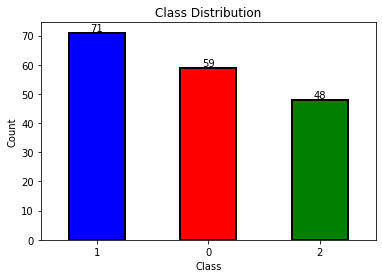

In [ ]:
# Plotting the distribution
class_counts = df['Target'].value_counts()

# Sort the classes based on counts
class_counts = class_counts.sort_values(ascending=False)

# Define colors for each class
colors = {0: 'red', 1: 'blue', 2: 'green'}

# Plot class distribution using a bar chart
ax = class_counts.plot(kind='bar', color=[colors[i] for i in class_counts.index], edgecolor='black', linewidth=2)

# Add data labels to each bar
for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height,
            int(height), ha='center', va='bottom')

# Add title & Lables
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')


# Rotate x-axis labels
plt.xticks(rotation=360)

# Show plot
plt.show()

In [ ]:
# Converting Pandas df to Spark DF
spark_df = spark.createDataFrame(df)
spark_df.head()

Row(alcohol=14.23, malic_acid=1.71, ash=2.43, alcalinity_of_ash=15.6, magnesium=127.0, total_phenols=2.8, flavanoids=3.06, nonflavanoid_phenols=0.28, proanthocyanins=2.29, color_intensity=5.64, hue=1.04, od280/od315_of_diluted_wines=3.92, proline=1065.0, Target=0)

In [ ]:
# Create the train & test split
train_df, test_df = spark_df.randomSplit([0.8,0.2], seed=142)

In [ ]:

# Assemble the feature into a fectore
Assembler = VectorAssembler(inputCols=wine_data.feature_names, outputCol='features')

# Instiate the Model
rf = RandomForestClassifier(labelCol='Target', featuresCol='features', predictionCol='predictions')

# Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Target", predictionCol="predictions", metricName="accuracy")

In [ ]:
# Setting up the Pipeline
pipeline = Pipeline(stages=[Assembler, rf])

In [ ]:
# Train the model
model = pipeline.fit(train_df)

In [ ]:
# Make the predictions
results= model.transform(test_df)

In [ ]:
# Check the results
Accuracy = evaluator.evaluate(results)
F1_Score = evaluator.setMetricName('f1').evaluate(results)
print('Accuracy:', Accuracy)
print('F1 Score:', F1_Score)

Accuracy: 0.9166666666666666
F1 Score: 0.9161395741092137
